# 🚀 XGBoost GPU Training - Full CIC-IoT-2023 Dataset
## Binary Classification: Benign vs Attack

---

**Pipeline:**
1. Read parquet metadata
2. Read labels & create train/test split
3. Load features (memory-optimized, column-by-column)
4. Create DMatrix & train with XGBoost **GPU (CUDA)**
5. Evaluate model
6. Save model & results

---

## 📦 Imports & Setup

In [1]:
import os
os.add_dll_directory(r'C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v13.1\bin\x64')

import numpy as np
import xgboost as xgb
import pyarrow.parquet as pq
import pyarrow as pa
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import time
import gc
import json
import subprocess
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Style settings for beautiful plots
plt.style.use('dark_background')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✅ All imports loaded successfully!")
print(f"📅 Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 XGBoost version: {xgb.__version__}")

✅ All imports loaded successfully!
📅 Started at: 2026-02-26 08:19:48
🔧 XGBoost version: 3.2.0


## 🎮 GPU Verification — التأكد من التدريب على الـ GPU

In [2]:
print("=" * 60)
print("🎮 GPU VERIFICATION")
print("=" * 60)

# 1. Quick GPU test with XGBoost CUDA
try:
    test_data = xgb.DMatrix(np.array([[1,2],[3,4]], dtype=np.float32), label=[0,1])
    test_params = {'tree_method': 'hist', 'device': 'cuda', 'verbosity': 0}
    test_bst = xgb.train(test_params, test_data, num_boost_round=1)
    del test_data, test_bst
    gpu_available = True
    print("✅ XGBoost CUDA (GPU) is AVAILABLE and WORKING!")
    print("   💡 التدريب هيتم على الـ GPU بالكامل ⚡")
except Exception as e:
    gpu_available = False
    print(f"❌ XGBoost CUDA NOT available: {e}")
    print("   ⚠️ التدريب هيتم على الـ CPU")

print()

# 2. nvidia-smi detailed info
try:
    result = subprocess.run(
        ['nvidia-smi', '--query-gpu=name,memory.total,memory.free,memory.used,driver_version,temperature.gpu,utilization.gpu,power.draw',
         '--format=csv,noheader,nounits'],
        capture_output=True, text=True, timeout=10
    )
    if result.returncode == 0:
        parts = [p.strip() for p in result.stdout.strip().split(',')]
        gpu_name = parts[0]
        vram_total = float(parts[1])
        vram_free = float(parts[2])
        vram_used = float(parts[3])
        driver_ver = parts[4]
        gpu_temp = parts[5]
        gpu_util = parts[6]
        power_draw = parts[7]

        print(f"🖥️  GPU Info:")
        print(f"   🔹 GPU Name:     {gpu_name}")
        print(f"   🔹 VRAM Total:   {vram_total/1024:.1f} GB ({vram_total:.0f} MB)")
        print(f"   🔹 VRAM Free:    {vram_free/1024:.1f} GB ({vram_free:.0f} MB)")
        print(f"   🔹 VRAM Used:    {vram_used/1024:.1f} GB ({vram_used:.0f} MB)")
        print(f"   🔹 Driver:       {driver_ver}")
        print(f"   🔹 Temperature:  {gpu_temp}°C")
        print(f"   🔹 Utilization:  {gpu_util}%")
        print(f"   🔹 Power Draw:   {power_draw}W")
    else:
        print(f"⚠️ nvidia-smi error: {result.stderr}")
except FileNotFoundError:
    print("⚠️ nvidia-smi not found in PATH")
except Exception as e:
    print(f"⚠️ Error: {e}")

# 3. CUDA Toolkit version
try:
    result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True, timeout=10)
    if result.returncode == 0:
        for line in result.stdout.strip().split('\n'):
            if 'release' in line.lower():
                print(f"   🔹 CUDA Toolkit: {line.strip()}")
except:
    pass

print()
print("=" * 60)
if gpu_available:
    print("🟢 STATUS: GPU READY — التدريب هيشتغل على كارت الشاشة 🚀")
else:
    print("🔴 STATUS: GPU NOT AVAILABLE — التدريب هيتم على CPU")
print("=" * 60)

🎮 GPU VERIFICATION


✅ XGBoost CUDA (GPU) is AVAILABLE and WORKING!
   💡 التدريب هيتم على الـ GPU بالكامل ⚡

🖥️  GPU Info:
   🔹 GPU Name:     NVIDIA RTX 5000 Ada Generation
   🔹 VRAM Total:   32.0 GB (32760 MB)
   🔹 VRAM Free:    29.8 GB (30496 MB)
   🔹 VRAM Used:    1.7 GB (1746 MB)
   🔹 Driver:       582.16
   🔹 Temperature:  42°C
   🔹 Utilization:  2%
   🔹 Power Draw:   32.07W
   🔹 CUDA Toolkit: Cuda compilation tools, release 12.1, V12.1.66

🟢 STATUS: GPU READY — التدريب هيشتغل على كارت الشاشة 🚀


## ⚙️ Configuration

In [3]:
# ============================================================
# Configuration
# ============================================================
PARQUET_PATH = 'processed/all_data_full.parquet'
MODEL_SAVE_PATH = 'models/xgb_full_model.json'
RESULTS_SAVE_PATH = 'models/training_results.json'
TRAIN_RATIO = 0.8
RANDOM_SEED = 42

# XGBoost hyperparameters — GPU TRAINING
XGB_PARAMS = {
    'tree_method': 'hist',       # Histogram-based algorithm
    'device': 'cuda',            # 🎮 GPU Training via CUDA
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc', 'error'],
    'max_depth': 8,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': 1,  # will be calculated from data
    'verbosity': 1,
    'seed': RANDOM_SEED
}
NUM_BOOST_ROUNDS = 300
EARLY_STOPPING_ROUNDS = 20

# Create output directory
os.makedirs('models', exist_ok=True)

# Display config
print("📋 Configuration:")
print(f"   Data:          {PARQUET_PATH}")
print(f"   Train ratio:   {TRAIN_RATIO}")
print(f"   Boost rounds:  {NUM_BOOST_ROUNDS}")
print(f"   Early stop:    {EARLY_STOPPING_ROUNDS}")
print(f"   Max depth:     {XGB_PARAMS['max_depth']}")
print(f"   Learning rate: {XGB_PARAMS['learning_rate']}")
print(f"   🎮 Device:     {XGB_PARAMS['device']} (GPU CUDA)")
print(f"   Tree method:   {XGB_PARAMS['tree_method']}")

📋 Configuration:
   Data:          processed/all_data_full.parquet
   Train ratio:   0.8
   Boost rounds:  300
   Early stop:    20
   Max depth:     8
   Learning rate: 0.1
   🎮 Device:     cuda (GPU CUDA)
   Tree method:   hist


## 📊 Step 1/6: Read Parquet Metadata

In [4]:
t_total_start = time.time()

pf = pq.ParquetFile(PARQUET_PATH)
total_rows = pf.metadata.num_rows
num_row_groups = pf.metadata.num_row_groups
schema = pf.schema_arrow
feature_cols = [f.name for f in schema if f.name != 'label']
n_features = len(feature_cols)

file_size_gb = os.path.getsize(PARQUET_PATH) / 1e9

print("=" * 60)
print("📁 Dataset Info")
print("=" * 60)
print(f"  📄 File:          {PARQUET_PATH}")
print(f"  💾 File size:     {file_size_gb:.2f} GB")
print(f"  📊 Total rows:    {total_rows:,}")
print(f"  📦 Row groups:    {num_row_groups}")
print(f"  🔢 Features:      {n_features} columns")
print("=" * 60)

# Display feature names
print(f"\n📋 Feature columns ({n_features}):")
for i, col in enumerate(feature_cols):
    print(f"   {i+1:2d}. {col}")

📁 Dataset Info
  📄 File:          processed/all_data_full.parquet
  💾 File size:     3.14 GB
  📊 Total rows:    46,686,579
  📦 Row groups:    999
  🔢 Features:      46 columns

📋 Feature columns (46):
    1. flow_duration
    2. Header_Length
    3. Protocol Type
    4. Duration
    5. Rate
    6. Srate
    7. Drate
    8. fin_flag_number
    9. syn_flag_number
   10. rst_flag_number
   11. psh_flag_number
   12. ack_flag_number
   13. ece_flag_number
   14. cwr_flag_number
   15. ack_count
   16. syn_count
   17. fin_count
   18. urg_count
   19. rst_count
   20. HTTP
   21. HTTPS
   22. DNS
   23. Telnet
   24. SMTP
   25. SSH
   26. IRC
   27. TCP
   28. UDP
   29. DHCP
   30. ARP
   31. ICMP
   32. IPv
   33. LLC
   34. Tot sum
   35. Min
   36. Max
   37. AVG
   38. Std
   39. Tot size
   40. IAT
   41. Number
   42. Magnitue
   43. Radius
   44. Covariance
   45. Variance
   46. Weight


## 🏷️ Step 2/6: Read Labels & Create Train/Test Split

In [5]:
t0 = time.time()
labels_table = pq.read_table(PARQUET_PATH, columns=['label'])
labels = labels_table.column('label').to_pylist()
del labels_table
gc.collect()

# Create binary labels
y = np.array([0 if l == 'BenignTraffic' else 1 for l in labels], dtype=np.int8)
del labels
gc.collect()

benign_count = int((y == 0).sum())
attack_count = int((y == 1).sum())

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = benign_count / attack_count if attack_count > 0 else 1.0
XGB_PARAMS['scale_pos_weight'] = round(scale_pos_weight, 4)

print(f"✅ Labels loaded in {time.time() - t0:.1f}s")
print(f"\n📊 Class Distribution:")
print(f"   🟢 Benign:  {benign_count:,} ({benign_count/len(y)*100:.2f}%)")
print(f"   🔴 Attack:  {attack_count:,} ({attack_count/len(y)*100:.2f}%)")
print(f"   ⚖️ Scale pos weight: {XGB_PARAMS['scale_pos_weight']:.4f}")

✅ Labels loaded in 78.5s

📊 Class Distribution:
   🟢 Benign:  1,098,195 (2.35%)
   🔴 Attack:  45,588,384 (97.65%)
   ⚖️ Scale pos weight: 0.0241


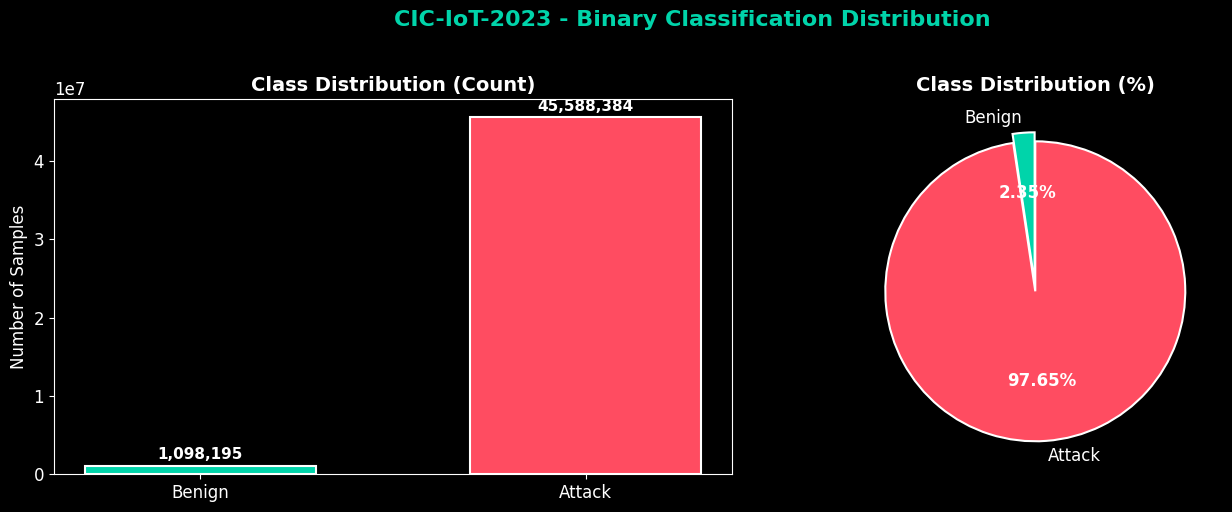

💾 Plot saved to models/class_distribution.png


In [6]:
# 📊 Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['#00D4AA', '#FF4C61']
bars = axes[0].bar(['Benign', 'Attack'], [benign_count, attack_count], color=colors, 
                     edgecolor='white', linewidth=1.5, width=0.6)
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold', color='white')
axes[0].set_ylabel('Number of Samples', fontsize=12)
for bar, count in zip(bars, [benign_count, attack_count]):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + total_rows*0.01,
                 f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold', color='white')

# Pie chart
wedges, texts, autotexts = axes[1].pie(
    [benign_count, attack_count], 
    labels=['Benign', 'Attack'],
    colors=colors,
    autopct='%1.2f%%',
    startangle=90,
    explode=(0.03, 0.03),
    textprops={'fontsize': 12, 'color': 'white'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)
for autotext in autotexts:
    autotext.set_fontweight('bold')
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold', color='white')

plt.suptitle('CIC-IoT-2023 - Binary Classification Distribution', fontsize=16, fontweight='bold', 
             color='#00D4AA', y=1.02)
plt.tight_layout()
plt.savefig('models/class_distribution.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print("💾 Plot saved to models/class_distribution.png")

In [7]:
# Train/Test split
np.random.seed(RANDOM_SEED)
indices = np.arange(len(y))
np.random.shuffle(indices)

split_point = int(len(y) * TRAIN_RATIO)
train_idx = np.sort(indices[:split_point])
test_idx = np.sort(indices[split_point:])
del indices
gc.collect()

y_train = y[train_idx]
y_test = y[test_idx]
del y
gc.collect()

print(f"✅ Train/Test Split:")
print(f"   🔵 Train: {len(train_idx):,} samples ({TRAIN_RATIO*100:.0f}%)")
print(f"   🟡 Test:  {len(test_idx):,} samples ({(1-TRAIN_RATIO)*100:.0f}%)")

✅ Train/Test Split:
   🔵 Train: 37,349,263 samples (80%)
   🟡 Test:  9,337,316 samples (20%)


## 📥 Step 3/6: Load Features (Memory-Optimized)

In [8]:
t0 = time.time()

# Pre-allocate train and test arrays directly
train_mem_gb = len(train_idx) * n_features * 4 / 1e9
test_mem_gb = len(test_idx) * n_features * 4 / 1e9
print(f"📦 Memory Allocation:")
print(f"   Train: ({len(train_idx):,} x {n_features}) float32 = {train_mem_gb:.2f} GB")
print(f"   Test:  ({len(test_idx):,} x {n_features}) float32 = {test_mem_gb:.2f} GB")
print(f"   Total: {train_mem_gb + test_mem_gb:.2f} GB")

X_train = np.empty((len(train_idx), n_features), dtype=np.float32)
X_test = np.empty((len(test_idx), n_features), dtype=np.float32)

# Read column by column - avoids holding full X in memory
print(f"\n⏳ Loading {n_features} columns...")
for i, col_name in enumerate(feature_cols):
    col_table = pq.read_table(PARQUET_PATH, columns=[col_name])
    col_array = col_table.column(0).to_numpy().astype(np.float32)
    del col_table

    # Handle inf/nan
    col_array = np.nan_to_num(col_array, nan=0.0, posinf=1e10, neginf=-1e10)

    # Split directly into train/test
    X_train[:, i] = col_array[train_idx]
    X_test[:, i] = col_array[test_idx]
    del col_array
    gc.collect()

    # Progress
    if (i + 1) % 5 == 0 or i == n_features - 1:
        elapsed = time.time() - t0
        eta = elapsed / (i + 1) * (n_features - i - 1)
        pct = (i+1)/n_features*100
        bar_len = 30
        filled = int(bar_len * (i+1) / n_features)
        bar = '█' * filled + '░' * (bar_len - filled)
        print(f"\r   [{bar}] {pct:.0f}% ({i+1}/{n_features}) | ⏱️ {elapsed:.0f}s | ETA: {eta:.0f}s", end="", flush=True)

print()  # newline
del train_idx, test_idx
gc.collect()

t_load = time.time() - t0
print(f"\n✅ Features loaded in {t_load:.1f}s ({t_load/60:.1f} min)")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_test shape:  {X_test.shape}")

📦 Memory Allocation:
   Train: (37,349,263 x 46) float32 = 6.87 GB
   Test:  (9,337,316 x 46) float32 = 1.72 GB
   Total: 8.59 GB

⏳ Loading 46 columns...


   [███░░░░░░░░░░░░░░░░░░░░░░░░░░░] 11% (5/46) | ⏱️ 47s | ETA: 388s

   [██████░░░░░░░░░░░░░░░░░░░░░░░░] 22% (10/46) | ⏱️ 85s | ETA: 305s

   [█████████░░░░░░░░░░░░░░░░░░░░░] 33% (15/46) | ⏱️ 114s | ETA: 235s

   [█████████████░░░░░░░░░░░░░░░░░] 43% (20/46) | ⏱️ 157s | ETA: 205s

   [████████████████░░░░░░░░░░░░░░] 54% (25/46) | ⏱️ 173s | ETA: 145s

   [███████████████████░░░░░░░░░░░] 65% (30/46) | ⏱️ 196s | ETA: 104s

   [██████████████████████░░░░░░░░] 76% (35/46) | ⏱️ 226s | ETA: 71s

   [██████████████████████████░░░░] 87% (40/46) | ⏱️ 271s | ETA: 41s

   [█████████████████████████████░] 98% (45/46) | ⏱️ 316s | ETA: 7s

   [██████████████████████████████] 100% (46/46) | ⏱️ 322s | ETA: 0s



✅ Features loaded in 321.9s (5.4 min)
   X_train shape: (37349263, 46)
   X_test shape:  (9337316, 46)


## 🏋️ Step 4/6: Create DMatrix & Train XGBoost on GPU 🎮

In [9]:
# Display XGBoost parameters
print("🔧 XGBoost Parameters:")
print("=" * 40)
for k, v in XGB_PARAMS.items():
    if k == 'device':
        print(f"   🎮 {k}: {v}  ← GPU TRAINING")
    else:
        print(f"   {k}: {v}")
print(f"   num_boost_rounds: {NUM_BOOST_ROUNDS}")
print(f"   early_stopping: {EARLY_STOPPING_ROUNDS}")
print("=" * 40)

# Create DMatrix
print(f"\n⏳ Creating DMatrix (train)...")
t0 = time.time()
dtrain = xgb.DMatrix(X_train, label=y_train)
del X_train, y_train
gc.collect()
print(f"   ✅ DMatrix train created in {time.time() - t0:.1f}s")

print(f"⏳ Creating DMatrix (test)...")
t0_dtest = time.time()
dtest = xgb.DMatrix(X_test, label=y_test)
del X_test
gc.collect()
print(f"   ✅ DMatrix test created in {time.time() - t0_dtest:.1f}s")

🔧 XGBoost Parameters:
   tree_method: hist
   🎮 device: cuda  ← GPU TRAINING
   objective: binary:logistic
   eval_metric: ['logloss', 'auc', 'error']
   max_depth: 8
   learning_rate: 0.1
   min_child_weight: 5
   subsample: 0.8
   colsample_bytree: 0.8
   reg_alpha: 0.1
   reg_lambda: 1.0
   scale_pos_weight: 0.0241
   verbosity: 1
   seed: 42
   num_boost_rounds: 300
   early_stopping: 20

⏳ Creating DMatrix (train)...


   ✅ DMatrix train created in 15.0s
⏳ Creating DMatrix (test)...


   ✅ DMatrix test created in 3.8s


In [10]:
# ============================================================
# 🚀🎮 GPU TRAINING
# ============================================================
print("🚀" * 20)
print("   🎮 STARTING GPU TRAINING (CUDA)...")
print(f"   Device: {XGB_PARAMS['device']} | Tree Method: {XGB_PARAMS['tree_method']}")
print("🚀" * 20)
print()

# Dictionary to store evaluation results for plotting
evals_result = {}

t_train_start = time.time()
bst = xgb.train(
    XGB_PARAMS,
    dtrain,
    num_boost_round=NUM_BOOST_ROUNDS,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    evals_result=evals_result,
    verbose_eval=10
)
t_train = time.time() - t_train_start

best_iteration = bst.best_iteration
best_score = bst.best_score
actual_rounds = best_iteration + 1

print(f"\n{'='*60}")
print(f"🎉 GPU Training Complete!")
print(f"{'='*60}")
print(f"   🎮 Trained on:     {XGB_PARAMS['device'].upper()} (GPU)")
print(f"   🏆 Best iteration:  {best_iteration}")
print(f"   📊 Best test score: {best_score:.6f}")
print(f"   ⏱️ Training time:   {t_train:.1f}s ({t_train/60:.1f} min)")
print(f"   🔄 Rounds trained:  {actual_rounds}")

# Free train DMatrix
del dtrain
gc.collect()

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
   🎮 STARTING GPU TRAINING (CUDA)...
   Device: cuda | Tree Method: hist
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀



[0]	train-logloss:0.60073	train-auc:0.99598	train-error:0.01548	test-logloss:0.60072	test-auc:0.99596	test-error:0.01542


[10]	train-logloss:0.19320	train-auc:0.99884	train-error:0.01207	test-logloss:0.19317	test-auc:0.99884	test-error:0.01204


[20]	train-logloss:0.08216	train-auc:0.99895	train-error:0.00967	test-logloss:0.08213	test-auc:0.99896	test-error:0.00964


[30]	train-logloss:0.04422	train-auc:0.99916	train-error:0.00844	test-logloss:0.04418	test-auc:0.99916	test-error:0.00841


[40]	train-logloss:0.03049	train-auc:0.99929	train-error:0.00738	test-logloss:0.03048	test-auc:0.99929	test-error:0.00735


[50]	train-logloss:0.02515	train-auc:0.99938	train-error:0.00701	test-logloss:0.02515	test-auc:0.99938	test-error:0.00698


[60]	train-logloss:0.02313	train-auc:0.99942	train-error:0.00681	test-logloss:0.02314	test-auc:0.99942	test-error:0.00679


[70]	train-logloss:0.02222	train-auc:0.99944	train-error:0.00669	test-logloss:0.02224	test-auc:0.99944	test-error:0.00668


[80]	train-logloss:0.02175	train-auc:0.99945	train-error:0.00660	test-logloss:0.02176	test-auc:0.99945	test-error:0.00658


[90]	train-logloss:0.02144	train-auc:0.99947	train-error:0.00652	test-logloss:0.02146	test-auc:0.99947	test-error:0.00651


[100]	train-logloss:0.02106	train-auc:0.99949	train-error:0.00640	test-logloss:0.02108	test-auc:0.99948	test-error:0.00639


[110]	train-logloss:0.02075	train-auc:0.99950	train-error:0.00630	test-logloss:0.02078	test-auc:0.99950	test-error:0.00630


[120]	train-logloss:0.02041	train-auc:0.99952	train-error:0.00620	test-logloss:0.02045	test-auc:0.99951	test-error:0.00620


[130]	train-logloss:0.02010	train-auc:0.99953	train-error:0.00611	test-logloss:0.02014	test-auc:0.99953	test-error:0.00611


[140]	train-logloss:0.01989	train-auc:0.99954	train-error:0.00604	test-logloss:0.01994	test-auc:0.99953	test-error:0.00605


[150]	train-logloss:0.01972	train-auc:0.99955	train-error:0.00599	test-logloss:0.01978	test-auc:0.99954	test-error:0.00600


[160]	train-logloss:0.01959	train-auc:0.99955	train-error:0.00595	test-logloss:0.01965	test-auc:0.99955	test-error:0.00596


[170]	train-logloss:0.01943	train-auc:0.99956	train-error:0.00591	test-logloss:0.01949	test-auc:0.99955	test-error:0.00591


[180]	train-logloss:0.01927	train-auc:0.99957	train-error:0.00587	test-logloss:0.01935	test-auc:0.99956	test-error:0.00587


[190]	train-logloss:0.01916	train-auc:0.99957	train-error:0.00583	test-logloss:0.01924	test-auc:0.99956	test-error:0.00584


[200]	train-logloss:0.01902	train-auc:0.99958	train-error:0.00580	test-logloss:0.01911	test-auc:0.99957	test-error:0.00580


[210]	train-logloss:0.01890	train-auc:0.99958	train-error:0.00576	test-logloss:0.01899	test-auc:0.99957	test-error:0.00577


[220]	train-logloss:0.01882	train-auc:0.99958	train-error:0.00574	test-logloss:0.01892	test-auc:0.99957	test-error:0.00575


[230]	train-logloss:0.01874	train-auc:0.99959	train-error:0.00572	test-logloss:0.01884	test-auc:0.99958	test-error:0.00573


[240]	train-logloss:0.01869	train-auc:0.99959	train-error:0.00570	test-logloss:0.01879	test-auc:0.99958	test-error:0.00571


[250]	train-logloss:0.01862	train-auc:0.99959	train-error:0.00568	test-logloss:0.01873	test-auc:0.99958	test-error:0.00569


[260]	train-logloss:0.01855	train-auc:0.99959	train-error:0.00566	test-logloss:0.01866	test-auc:0.99958	test-error:0.00567


[270]	train-logloss:0.01849	train-auc:0.99960	train-error:0.00564	test-logloss:0.01860	test-auc:0.99958	test-error:0.00565


[280]	train-logloss:0.01840	train-auc:0.99960	train-error:0.00561	test-logloss:0.01852	test-auc:0.99959	test-error:0.00563


[290]	train-logloss:0.01834	train-auc:0.99960	train-error:0.00560	test-logloss:0.01847	test-auc:0.99959	test-error:0.00561


[299]	train-logloss:0.01828	train-auc:0.99960	train-error:0.00558	test-logloss:0.01841	test-auc:0.99959	test-error:0.00559



🎉 GPU Training Complete!
   🎮 Trained on:     CUDA (GPU)
   🏆 Best iteration:  299
   📊 Best test score: 0.005594
   ⏱️ Training time:   46.7s (0.8 min)
   🔄 Rounds trained:  300


20

C:\Users\digilians01\AppData\Local\Temp\ipykernel_8480\2912212527.py:26: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\digilians01\AppData\Local\Temp\ipykernel_8480\2912212527.py:27: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('models/training_curves.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')


D:\Ml Project\iot_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


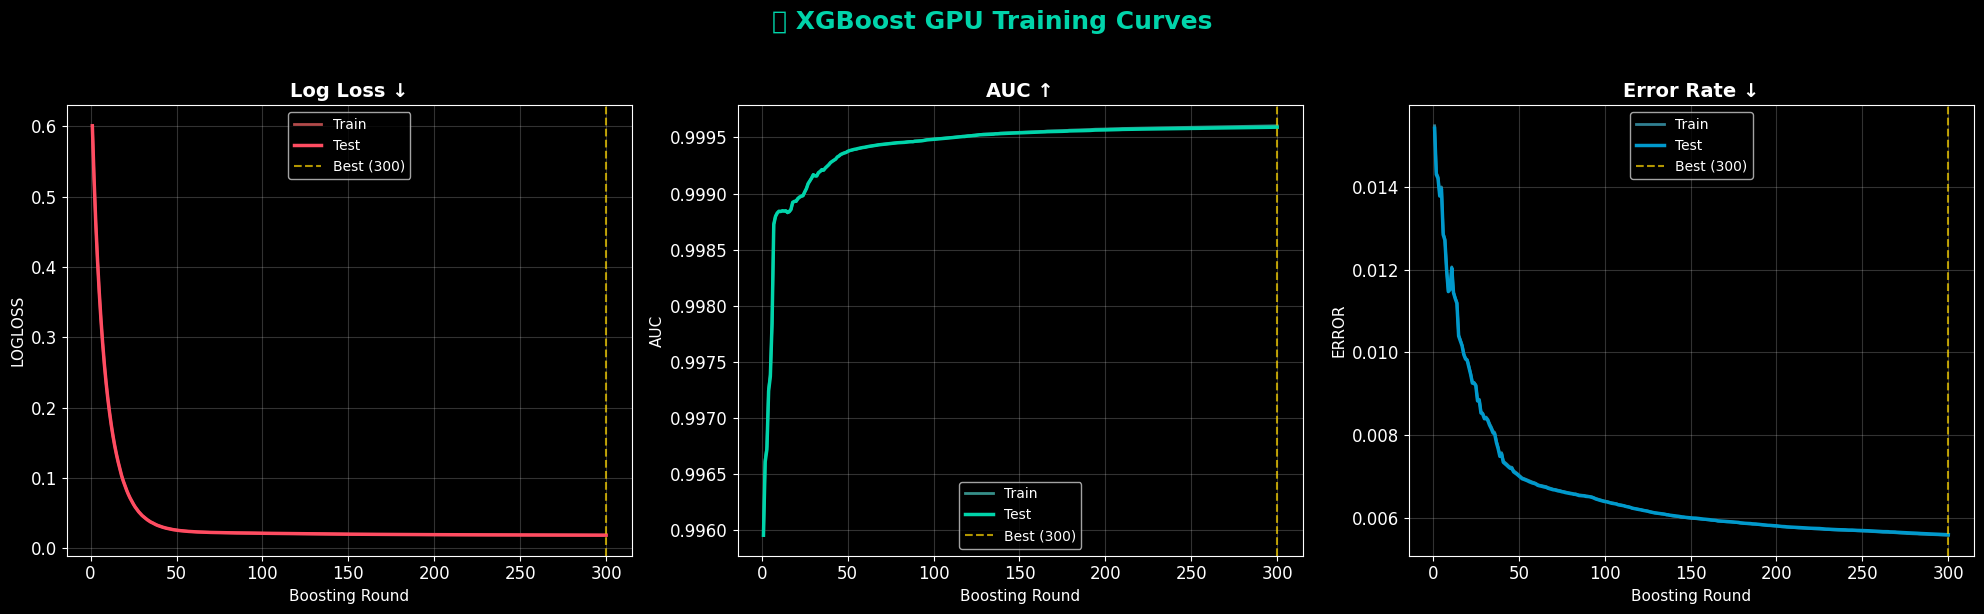

💾 Plot saved to models/training_curves.png


In [11]:
# 📈 Plot Training Curves
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

metrics_to_plot = ['logloss', 'auc', 'error']
titles = ['Log Loss ↓', 'AUC ↑', 'Error Rate ↓']
colors_train = ['#FF6B6B', '#4ECDC4', '#45B7D1']
colors_test = ['#FF4C61', '#00D4AA', '#0099CC']

for ax, metric, title, ct, cv in zip(axes, metrics_to_plot, titles, colors_train, colors_test):
    if metric in evals_result.get('train', {}):
        train_vals = evals_result['train'][metric]
        test_vals = evals_result['test'][metric]
        epochs = range(1, len(train_vals) + 1)
        
        ax.plot(epochs, train_vals, color=ct, alpha=0.7, linewidth=2, label='Train')
        ax.plot(epochs, test_vals, color=cv, linewidth=2.5, label='Test')
        ax.axvline(x=best_iteration+1, color='#FFD700', linestyle='--', alpha=0.7, label=f'Best ({best_iteration+1})')
        
        ax.set_title(title, fontsize=14, fontweight='bold', color='white')
        ax.set_xlabel('Boosting Round', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.2)

plt.suptitle('📈 XGBoost GPU Training Curves', fontsize=18, fontweight='bold', color='#00D4AA', y=1.02)
plt.tight_layout()
plt.savefig('models/training_curves.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print("💾 Plot saved to models/training_curves.png")

## 📊 Step 5/6: Evaluate Model

In [12]:
# Predictions
y_pred_prob = bst.predict(dtest, iteration_range=(0, best_iteration + 1))
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1_binary = f1_score(y_test, y_pred, average='binary')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

report = classification_report(y_test, y_pred, target_names=['Benign', 'Attack'])

print("=" * 60)
print("🏆 RESULTS - XGBoost GPU (Binary Classification)")
print("=" * 60)
print(f"  🎮 Trained on:     GPU ({XGB_PARAMS['device']})")
print(f"  📊 Dataset:        {total_rows:,} rows x {n_features} features")
print(f"  🧪 Test samples:   {len(y_test):,}")
print(f"  ✅ Accuracy:       {acc*100:.4f}%")
print(f"  🎯 F1-Score (bin): {f1_binary*100:.4f}%")
print(f"  📏 F1-Score (wtd): {f1_weighted*100:.4f}%")
print(f"  📐 F1-Score (mac): {f1_macro*100:.4f}%")
print(f"  🎯 Precision:      {precision_val*100:.4f}%")
print(f"  📡 Recall:         {recall_val*100:.4f}%")
print(f"  🛡️ Specificity:    {specificity*100:.4f}%")
print(f"  ⚠️ FPR:            {fpr*100:.4f}%")
print("=" * 60)

print(f"\n📋 Classification Report:")
print(report)

🏆 RESULTS - XGBoost GPU (Binary Classification)
  🎮 Trained on:     GPU (cuda)
  📊 Dataset:        46,686,579 rows x 46 features
  🧪 Test samples:   9,337,316
  ✅ Accuracy:       99.4406%
  🎯 F1-Score (bin): 99.7127%
  📏 F1-Score (wtd): 99.4693%
  📐 F1-Score (mac): 94.5500%
  🎯 Precision:      99.9979%
  📡 Recall:         99.4292%
  🛡️ Specificity:    99.9142%
  ⚠️ FPR:            0.0858%

📋 Classification Report:
              precision    recall  f1-score   support

      Benign       0.81      1.00      0.89    220158
      Attack       1.00      0.99      1.00   9117158

    accuracy                           0.99   9337316
   macro avg       0.90      1.00      0.95   9337316
weighted avg       1.00      0.99      0.99   9337316



C:\Users\digilians01\AppData\Local\Temp\ipykernel_8480\2184253283.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\digilians01\AppData\Local\Temp\ipykernel_8480\2184253283.py:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('models/confusion_matrix.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')


D:\Ml Project\iot_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


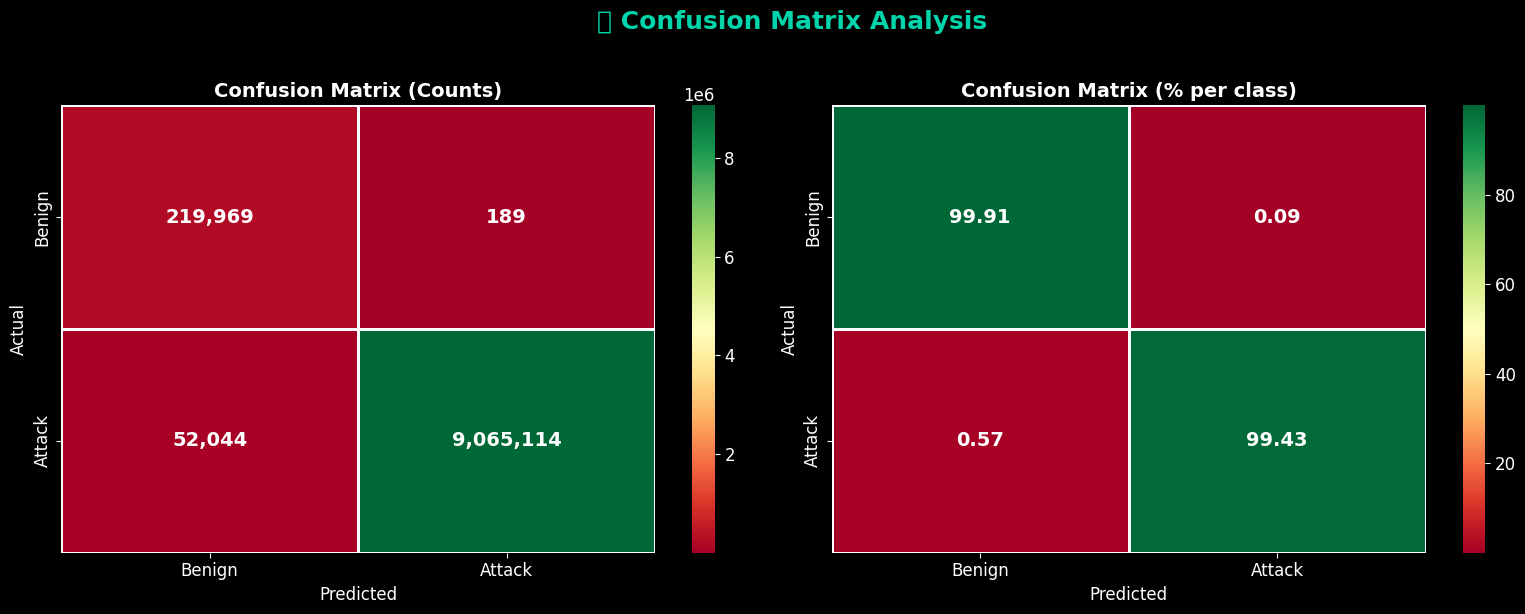

💾 Plot saved to models/confusion_matrix.png


In [13]:
# 📊 Confusion Matrix Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts confusion matrix
sns.heatmap(cm, annot=True, fmt=',d', cmap='RdYlGn', 
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'],
            ax=axes[0], linewidths=2, linecolor='white',
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold', color='white')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'],
            ax=axes[1], linewidths=2, linecolor='white',
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
axes[1].set_title('Confusion Matrix (% per class)', fontsize=14, fontweight='bold', color='white')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.suptitle('📊 Confusion Matrix Analysis', fontsize=18, fontweight='bold', color='#00D4AA', y=1.02)
plt.tight_layout()
plt.savefig('models/confusion_matrix.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print("💾 Plot saved to models/confusion_matrix.png")

C:\Users\digilians01\AppData\Local\Temp\ipykernel_8480\637823627.py:28: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\digilians01\AppData\Local\Temp\ipykernel_8480\637823627.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('models/metrics_summary.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')


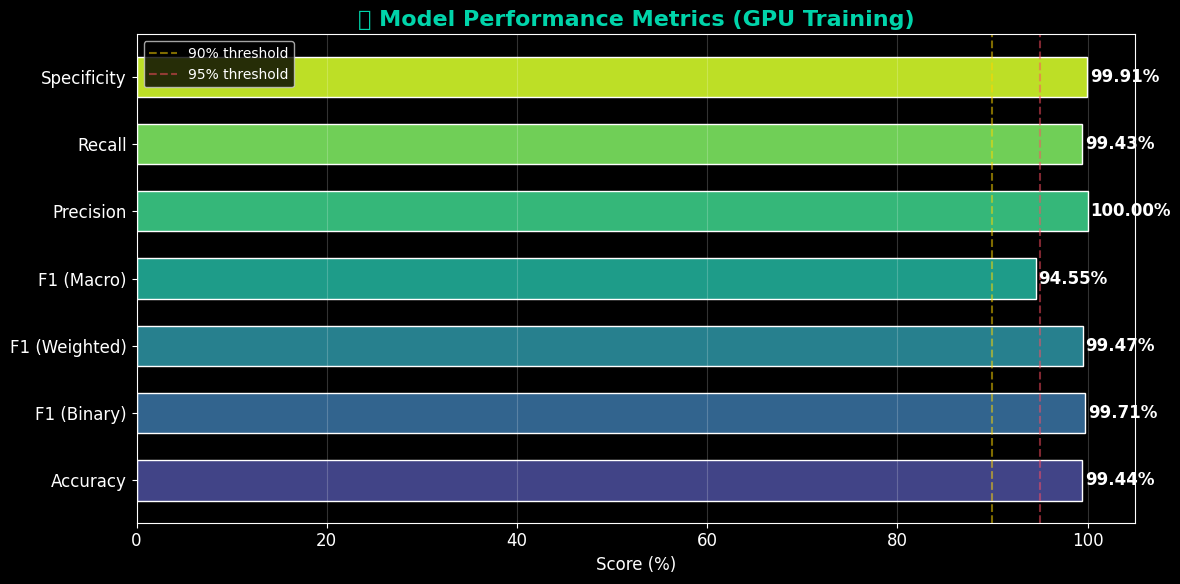

💾 Plot saved to models/metrics_summary.png


In [14]:
# 📊 Metrics Summary Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))

metrics_names = ['Accuracy', 'F1 (Binary)', 'F1 (Weighted)', 'F1 (Macro)', 
                 'Precision', 'Recall', 'Specificity']
metrics_values = [acc*100, f1_binary*100, f1_weighted*100, f1_macro*100,
                  precision_val*100, recall_val*100, specificity*100]

# Color gradient
colors_metrics = plt.cm.viridis(np.linspace(0.2, 0.9, len(metrics_names)))

bars = ax.barh(metrics_names, metrics_values, color=colors_metrics, 
                edgecolor='white', linewidth=1, height=0.6)

# Add value labels
for bar, val in zip(bars, metrics_values):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2.,
            f'{val:.2f}%', ha='left', va='center', fontsize=12, fontweight='bold', color='white')

ax.set_xlim(0, 105)
ax.set_title('📊 Model Performance Metrics (GPU Training)', fontsize=16, fontweight='bold', color='#00D4AA')
ax.set_xlabel('Score (%)', fontsize=12)
ax.axvline(x=90, color='#FFD700', linestyle='--', alpha=0.5, label='90% threshold')
ax.axvline(x=95, color='#FF4C61', linestyle='--', alpha=0.5, label='95% threshold')
ax.legend(fontsize=10)
ax.grid(True, axis='x', alpha=0.2)

plt.tight_layout()
plt.savefig('models/metrics_summary.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print("💾 Plot saved to models/metrics_summary.png")

C:\Users\digilians01\AppData\Local\Temp\ipykernel_8480\3746790829.py:38: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\digilians01\AppData\Local\Temp\ipykernel_8480\3746790829.py:39: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.savefig('models/feature_importance.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')


D:\Ml Project\iot_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


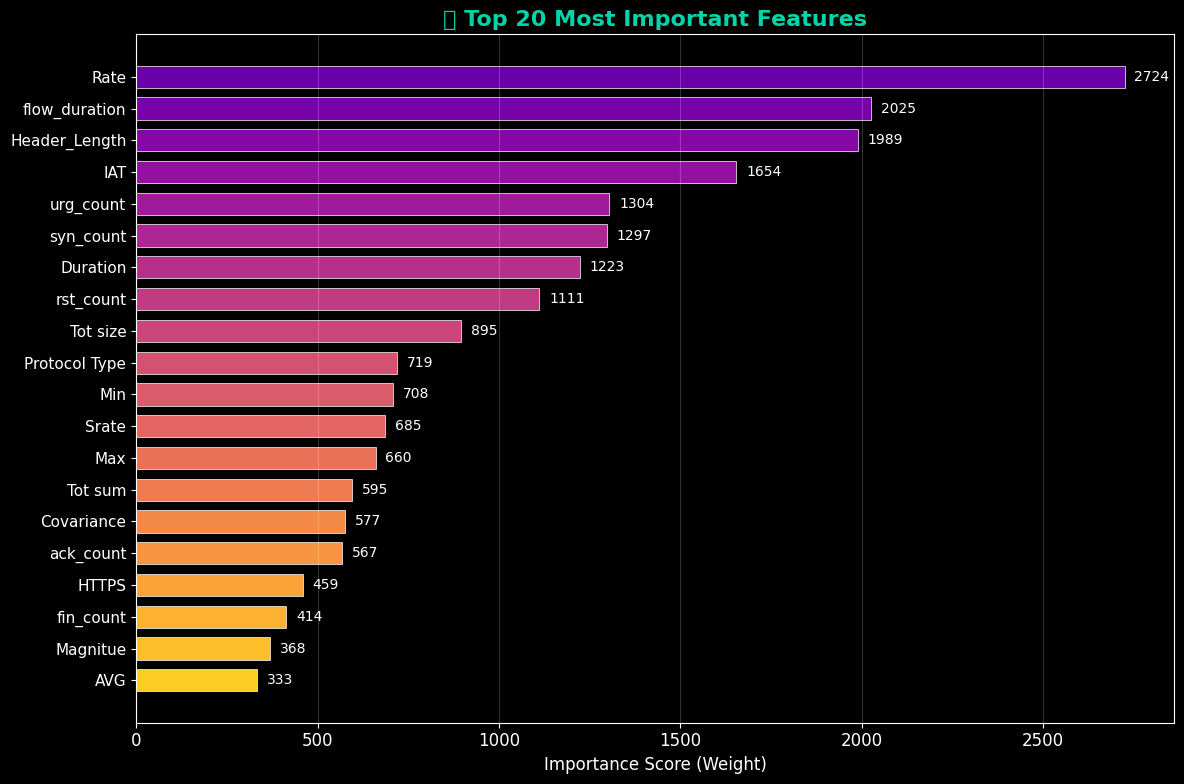

💾 Plot saved to models/feature_importance.png

📋 Top 20 Features:
    1. Rate                           = 2724
    2. flow_duration                  = 2025
    3. Header_Length                  = 1989
    4. IAT                            = 1654
    5. urg_count                      = 1304
    6. syn_count                      = 1297
    7. Duration                       = 1223
    8. rst_count                      = 1111
    9. Tot size                       = 895
   10. Protocol Type                  = 719
   11. Min                            = 708
   12. Srate                          = 685
   13. Max                            = 660
   14. Tot sum                        = 595
   15. Covariance                     = 577
   16. ack_count                      = 567
   17. HTTPS                          = 459
   18. fin_count                      = 414
   19. Magnitue                       = 368
   20. AVG                            = 333


In [15]:
# 📊 Feature Importance (Top 20)
importance = bst.get_score(importance_type='weight')
sorted_imp = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:20]

# Map feature names
imp_names = []
imp_scores = []
for fname, score in sorted_imp:
    if fname.startswith('f'):
        try:
            fidx = int(fname[1:])
            fname_actual = feature_cols[fidx] if fidx < len(feature_cols) else fname
        except ValueError:
            fname_actual = fname
    else:
        fname_actual = fname
    imp_names.append(fname_actual)
    imp_scores.append(score)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

colors_imp = plt.cm.plasma(np.linspace(0.2, 0.9, len(imp_names)))
y_pos = range(len(imp_names) - 1, -1, -1)

bars = ax.barh(y_pos, imp_scores, color=colors_imp, edgecolor='white', linewidth=0.5, height=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(imp_names, fontsize=11)

for bar, score in zip(bars, imp_scores):
    ax.text(bar.get_width() + max(imp_scores)*0.01, bar.get_y() + bar.get_height()/2.,
            f'{score:.0f}', ha='left', va='center', fontsize=10, color='white')

ax.set_title('🏆 Top 20 Most Important Features', fontsize=16, fontweight='bold', color='#00D4AA')
ax.set_xlabel('Importance Score (Weight)', fontsize=12)
ax.grid(True, axis='x', alpha=0.2)

plt.tight_layout()
plt.savefig('models/feature_importance.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print("💾 Plot saved to models/feature_importance.png")

# Also print the list
print(f"\n📋 Top 20 Features:")
for rank, (name, score) in enumerate(zip(imp_names, imp_scores), 1):
    print(f"   {rank:2d}. {name:<30s} = {score:.0f}")

C:\Users\digilians01\AppData\Local\Temp\ipykernel_8480\2348234860.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\digilians01\AppData\Local\Temp\ipykernel_8480\2348234860.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('models/prediction_distribution.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')


D:\Ml Project\iot_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


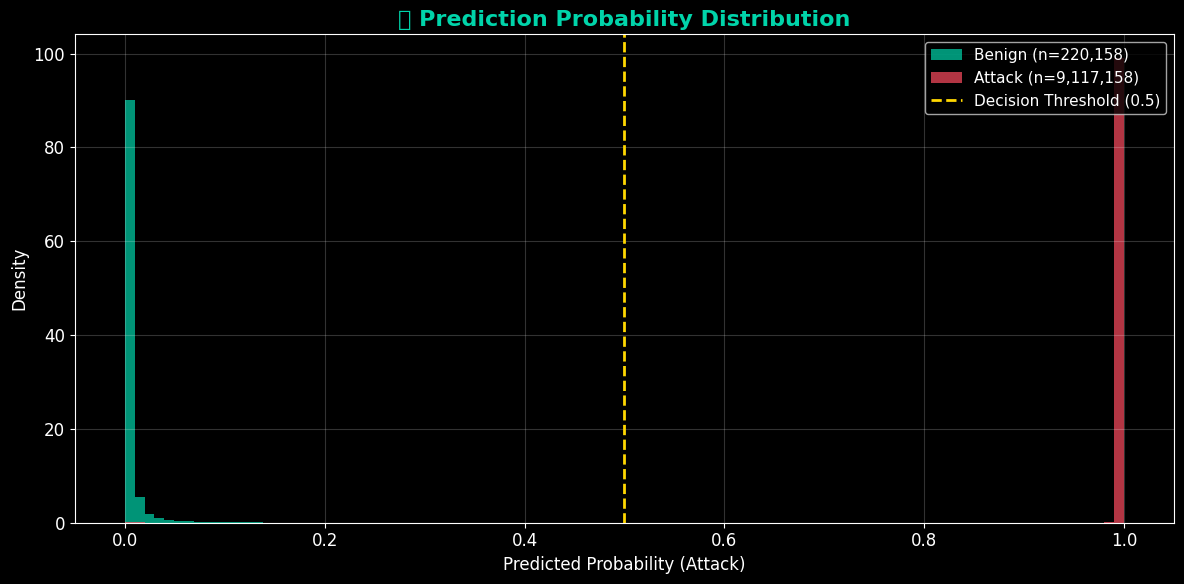

💾 Plot saved to models/prediction_distribution.png


In [16]:
# 📊 Prediction Probability Distribution
fig, ax = plt.subplots(figsize=(12, 6))

# Plot histogram for benign and attack predictions
mask_benign = y_test == 0
mask_attack = y_test == 1

ax.hist(y_pred_prob[mask_benign], bins=100, alpha=0.7, color='#00D4AA', 
        label=f'Benign (n={mask_benign.sum():,})', density=True)
ax.hist(y_pred_prob[mask_attack], bins=100, alpha=0.7, color='#FF4C61', 
        label=f'Attack (n={mask_attack.sum():,})', density=True)

ax.axvline(x=0.5, color='#FFD700', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')

ax.set_title('📊 Prediction Probability Distribution', fontsize=16, fontweight='bold', color='#00D4AA')
ax.set_xlabel('Predicted Probability (Attack)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('models/prediction_distribution.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print("💾 Plot saved to models/prediction_distribution.png")

## 💾 Step 6/6: Save Model & Results

In [17]:
# Save model
bst.save_model(MODEL_SAVE_PATH)
model_size = os.path.getsize(MODEL_SAVE_PATH) / 1e6
print(f"✅ Model saved to: {MODEL_SAVE_PATH} ({model_size:.1f} MB)")

# Save results as JSON
t_total = time.time() - t_total_start
results = {
    'timestamp': datetime.now().isoformat(),
    'training_device': 'GPU (CUDA)',
    'dataset': {
        'path': PARQUET_PATH,
        'total_rows': total_rows,
        'n_features': n_features,
        'feature_names': feature_cols,
        'benign_count': benign_count,
        'attack_count': attack_count,
        'train_size': int(split_point),
        'test_size': int(total_rows - split_point)
    },
    'model': {
        'type': 'XGBoost',
        'device': 'cuda (GPU)',
        'params': {k: str(v) if isinstance(v, list) else v for k, v in XGB_PARAMS.items()},
        'num_boost_rounds_requested': NUM_BOOST_ROUNDS,
        'actual_rounds_trained': actual_rounds,
        'best_iteration': best_iteration,
        'best_score': float(best_score),
        'early_stopping_rounds': EARLY_STOPPING_ROUNDS,
        'model_path': MODEL_SAVE_PATH
    },
    'metrics': {
        'accuracy': float(acc),
        'f1_binary': float(f1_binary),
        'f1_weighted': float(f1_weighted),
        'f1_macro': float(f1_macro),
        'precision': float(precision_val),
        'recall': float(recall_val),
        'specificity': float(specificity),
        'fpr': float(fpr),
        'confusion_matrix': {
            'tn': int(tn), 'fp': int(fp),
            'fn': int(fn), 'tp': int(tp)
        }
    },
    'timing': {
        'data_loading_seconds': round(t_load, 1),
        'training_seconds': round(t_train, 1),
        'total_seconds': round(t_total, 1)
    },
    'feature_importance_top20': [
        {'feature': name, 'importance': float(score)}
        for name, score in zip(imp_names, imp_scores)
    ]
}

with open(RESULTS_SAVE_PATH, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)
print(f"✅ Results saved to: {RESULTS_SAVE_PATH}")

✅ Model saved to: models/xgb_full_model.json (2.8 MB)
✅ Results saved to: models/training_results.json


In [18]:
# ============================================================
# 🎉 FINAL SUMMARY
# ============================================================
print("\n" + "🏆" * 30)
print()
print(f"  {'='*56}")
print(f"  🎉 TRAINING COMPLETE!")
print(f"  {'='*56}")
print(f"  📅 Timestamp:      {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"  🎮 Device:         GPU (CUDA)")
print(f"  ⏱️ Total time:     {t_total:.1f}s ({t_total/60:.1f} min)")
print(f"  📥 Data loading:   {t_load:.1f}s")
print(f"  🎮 GPU Training:   {t_train:.1f}s ({actual_rounds} rounds)")
print(f"  {'─'*56}")
print(f"  ✅ Accuracy:       {acc*100:.4f}%")
print(f"  🎯 F1-Score:       {f1_binary*100:.4f}%")
print(f"  🎯 Precision:      {precision_val*100:.4f}%")
print(f"  📡 Recall:         {recall_val*100:.4f}%")
print(f"  {'─'*56}")
print(f"  💾 Model:          {MODEL_SAVE_PATH} ({model_size:.1f} MB)")
print(f"  📋 Results:        {RESULTS_SAVE_PATH}")
print(f"  {'='*56}")
print()
print("🏆" * 30)


🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆

  🎉 TRAINING COMPLETE!
  📅 Timestamp:      2026-02-26 08:27:48
  🎮 Device:         GPU (CUDA)
  ⏱️ Total time:     479.6s (8.0 min)
  📥 Data loading:   321.9s
  🎮 GPU Training:   46.7s (300 rounds)
  ────────────────────────────────────────────────────────
  ✅ Accuracy:       99.4406%
  🎯 F1-Score:       99.7127%
  🎯 Precision:      99.9979%
  📡 Recall:         99.4292%
  ────────────────────────────────────────────────────────
  💾 Model:          models/xgb_full_model.json (2.8 MB)
  📋 Results:        models/training_results.json

🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
